# Classificação de gastos e agrupamento de clientes de acordo com perfil de compra


__As bases utilizadas neste estudo não são reais, portanto os resultados não possuem validade prática, apesar de exemplificar um case real e aplicável.__

In [1]:
import pandas as pd
import unidecode
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import os
from operator import itemgetter
import numpy as np


nltk.download('rslp')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package rslp to /home/zeus/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv('data/train_data.csv', sep=',')
df.head()

customerId      date amount                       description  categoria
0    17899571  25/08/15   5,85  2 via CARTAODEBITO               PF_CARTAO
1     9904554  04/04/14    5,3  2 via CARTAODEBITO               PF_CARTAO
2    22767856  09/03/15    5,3  2 via CARTAODEBITO               PF_CARTAO
3    22767856  25/03/15    5,3  2 via CARTAODEBITO               PF_CARTAO
4    14568932  11/07/14    5,3  2 via CARTAODEBITO               PF_CARTAO

In [3]:
print('Nro de classes: ', len(df['categoria'].value_counts()))
df['categoria'].value_counts()

Nro de classes:  26


G_VEICULO              271
G_CASA                 237
G_MERCADO              211
G_INTERNET_TELEFONE    182
PF_SEGUROS             181
G_RESTAURANTE          145
G_MATCONSTRUCAO        107
G_SAUDE                103
G_VESTUARIO             61
G_DOCERIA               60
G_LOJADEPTO             54
PF_CARTAO               54
G_BAR_CERVEJARIA        39
G_TRANSPORTE            32
PF_CONSORCIO            26
G_CASA_CARNE            23
PF_FINANCIAMENTO        23
G_COSMETICO_BELEZA      23
G_ANIMAL                20
G_HORTIFRUTI            16
G_ESPORTE               12
G_LIVRARIA              12
G_INFANTIL              10
G_VIAGEM                10
G_EDUCACAO              10
G_CINEMA                 6
Name: categoria, dtype: int64

## Pré processamento

In [4]:
with open('data/stopwords.txt', 'r') as f:
    stopset = f.readlines()
stopset = [s.replace('\n', '') for s in stopset]

In [5]:
def tokenize(text):
    tokens = text.split(' ')
    res = []
    for t in tokens:
        if len(t) > 1 and t != '\x1f':
            res.append(t)
    return res

def remove_by_len(text, min_len=2):
    return [t for t in text if len(t) > 2]

def remove_stopwords(text):
    return [t for t in text if t not in stopset]

def clean(text):
    return [unidecode.unidecode(t) for t in text]

def remove_numbers(text):
    text = [re.sub('[0-9]+', '', t) for t in text]
    return text

def remove_special_characters(text):
    text = [re.sub('[^a-z\s]', '', t) for t in text]
    return text

df['description_preprocess'] = df['description'].apply(lambda x: x.lower())
df['description_preprocess'] = df['description_preprocess'].apply(tokenize)
df['description_preprocess'] = df['description_preprocess'].apply(remove_by_len)
df['description_preprocess'] = df['description_preprocess'].apply(remove_stopwords)
df['description_preprocess'] = df['description_preprocess'].apply(clean)
df['description_preprocess'] = df['description_preprocess'].apply(remove_stopwords)
df['description_preprocess'] = df['description_preprocess'].apply(remove_numbers)
df['description_preprocess'] = df['description_preprocess'].apply(remove_special_characters)

In [8]:
df.iloc[50:100]

customerId      date   amount             description           categoria  \
50    17899571  30/01/15     8,49                 ACOUGUE        G_CASA_CARNE   
51    17899571  01/03/16      215    AGRICOLA HELENA LTDA            G_ANIMAL   
52    24798702  02/12/15    97,44          AGUA DE CHEIRO  G_COSMETICO_BELEZA   
53     9589230  12/06/15     9,78               AKI FRIOS           G_MERCADO   
54    23953783  25/05/15       50    ALESAT AUTO POSTO IA           G_VEICULO   
55    23953783  24/07/15       30    ALESAT AUTO POSTO IA           G_VEICULO   
56    17899571  15/01/16      145      ALESAT POSTO RADAR           G_VEICULO   
57    17899571  06/01/16      130      ALESAT POSTO RADAR           G_VEICULO   
58    22767856  26/01/16   102,44                ALO BEBE          G_INFANTIL   
59    22767856  12/01/15    173,3                ALO BEBE          G_INFANTIL   
60    22767856  29/02/16   319,88                ALO BEBE          G_INFANTIL   
61    22767856  31/08/15    424,6                ALO BEBE          G_INFANTIL   
62    22767856  25/01/16   102,44                ALO BEBE          G_INFANTIL   
63    14568932  24/08/15       30       ALTERNATIVA MODAS         G_VESTUARIO   
64     9589230  20/10/14    75,18                ALUMIACO     G_MATCONSTRUCAO   
65     9589230  09/12/14       53    ALUMICENTER COM META     G_MATCONSTRUCAO   
66     9589230  08/12/14       53    ALUMICENTER COM META     G_MATCONSTRUCAO   
67     9589230  31/07/14   236,76    ALUMICENTER COM META     G_MATCONSTRUCAO   
68     9589230  20/11/14       70       ALUMINIO SALVADOR     G_MATCONSTRUCAO   
69     9589230  30/01/15   236,21             ALUMIVIDROS     G_MATCONSTRUCAO   
70     9589230  26/01/15       28             ALUMIVIDROS     G_MATCONSTRUCAO   
71     9589230  12/02/15       40             ALUMIVIDROS     G_MATCONSTRUCAO   
72     9589230  11/09/15   122,32             ALUMIVIDROS     G_MATCONSTRUCAO   
73     9589230  17/04/15       34             ALUMIVIDROS     G_MATCONSTRUCAO   
74     9589230  06/10/14      152             ALUMIVIDROS     G_MATCONSTRUCAO   
75     9589230  16/01/15      406             ALUMIVIDROS     G_MATCONSTRUCAO   
76     9589230  27/01/15    71,95             ALUMIVIDROS     G_MATCONSTRUCAO   
77     9589230  23/10/14      114             ALUMIVIDROS     G_MATCONSTRUCAO   
78     9589230  30/04/15    40,64             ALUMIVIDROS     G_MATCONSTRUCAO   
79     9589230  23/10/14    32,99             ALUMIVIDROS     G_MATCONSTRUCAO   
80     9589230  23/01/15       99             ALUMIVIDROS     G_MATCONSTRUCAO   
81     9589230  27/01/15     14,5             ALUMIVIDROS     G_MATCONSTRUCAO   
82     9589230  27/01/15   954,69             ALUMIVIDROS     G_MATCONSTRUCAO   
83    22767856  15/04/15   525,91              AMEX ABR15           PF_CARTAO   
84    22767856  18/08/14   369,51            AMEX AGO2014           PF_CARTAO   
85    22767856  19/12/14   587,96              AMEX DEZ14           PF_CARTAO   
86    22767856  26/01/15   525,51              AMEX JAN15           PF_CARTAO   
87    22767856  18/01/16    42,24              AMEX JAN16           PF_CARTAO   
88    22767856  13/07/15   295,78              AMEX JUL15           PF_CARTAO   
89    22767856  30/11/15      729              AMEX NOV15           PF_CARTAO   
90    22767856  22/10/14   545,73              AMEX OUT14           PF_CARTAO   
91    22767856  24/09/14    526,1              AMEX SET14           PF_CARTAO   
92    35622577  28/04/14  1077,66              APTO 4/300              G_CASA   
93    17899571  30/07/14       25  AQUARIUM AUTO POSTO LT           G_VEICULO   
94     9589230  08/09/15       13      ARCA DA CONSTRUCAO     G_MATCONSTRUCAO   
95     9589230  29/07/15      115         ARENA DA BELEZA  G_COSMETICO_BELEZA   
96    20304573  25/08/14   234,75                  AREZZO         G_VESTUARIO   
97    17899571  21/12/15   328,51        ASSAI ATACADISTA         G_LOJADEPTO   
98    17899571  02/02/16   130,42  

In [16]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(sentences=df['description_preprocess'], min_count=2, window=1, size=300, workers=4)

In [17]:
most_sim = w2v_model.most_similar(positive=['posto'])
most_sim

/home/zeus/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bertoli', 0.22621339559555054),
 ('auto', 0.1970098912715912),
 ('camarao', 0.17853239178657532),
 ('mega', 0.17011085152626038),
 ('cacau', 0.17009565234184265),
 ('bpm', 0.16796176135540009),
 ('redencao', 0.1659741848707199),
 ('americanas', 0.16335265338420868),
 ('pecas', 0.1627369076013565),
 ('amex', 0.16189567744731903)]

#### A função abaixo é auxiliar, serve para plotar os dados extraídos do word2vec

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, dim, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, dim), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA().fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/home/zeus/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [19]:
tsnescatterplot(w2v_model, "pizzaria", 300, [t[0] for t in w2v_model.wv.most_similar(positive=["pizzaria"], topn=20)][10:])

##### Antes de executar o passo abaixo, baixar do link o cbow 300 dimensões, descompactar e colocar na pasta data

Modelo word2vec baixado do site do NILC: http://www.nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

In [20]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load_word2vec_format('data/cbow_s300.txt')

In [21]:
vect = w2v_model.most_similar(positive=['cachorro-quente'])
vect

[('hambúrguer', 0.6931670904159546),
 ('sanduíche', 0.6911150217056274),
 ('sorvete', 0.682384192943573),
 ('bolinho', 0.6588199138641357),
 ('milk-shake', 0.6506005525588989),
 ('hamburguer', 0.6485681533813477),
 ('pretzel', 0.6380558609962463),
 ('bolo', 0.6367464065551758),
 ('sanduã\xadche', 0.6300495266914368),
 ('pãozinho', 0.6278306245803833)]

/home/zeus/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/home/zeus/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/zeus/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/zeus/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/zeus/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


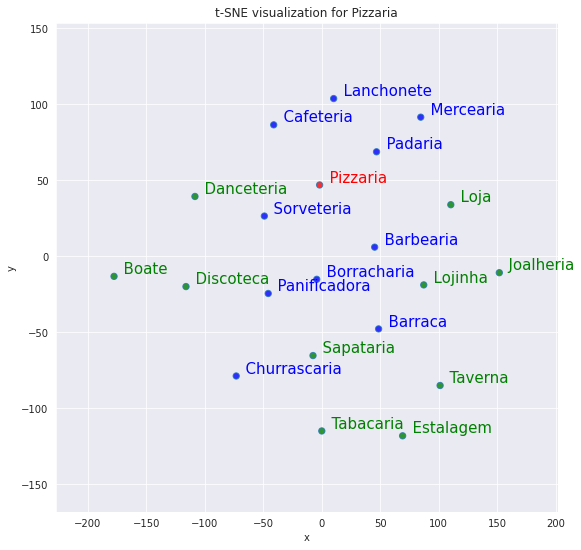

In [22]:
tsnescatterplot(w2v_model, "pizzaria", 300, [t[0] for t in w2v_model.wv.most_similar(positive=["pizzaria"], topn=20)][10:])

In [23]:
def context_expansion(tokens):
    result = []
    for t in tokens:
        result.append(t)
        try:
            most_sim = model.most_similar(positive=[t], topn=1)[0]
            if(most_sim[1] > 0.65):
                result.append(most_sim[0])
        except:
            continue
    return result

df['description_preprocess_w2v'] = df['description_preprocess'].apply(context_expansion)

In [24]:
stemmer = nltk.stem.RSLPStemmer()

def stem(text):
    result = []
    for t in text:
        if len(t) > 1:
            result.append(stemmer.stem(t))
    return result

df['description_preprocess_w2v_stem'] = df['description_preprocess_w2v'].apply(stem)

In [25]:
df['description_preprocess_w2v_stem'] = df['description_preprocess_w2v'].apply(lambda x: ' '.join(x))

### Estruturação dos dados em BoW utilizando Tfidf e criação do modelo de classificação

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2))
X, y = vectorizer.fit_transform(df['description_preprocess_w2v_stem']), df['categoria']

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

y_pred = xgboost.predict(X_test)

accuracy_score(y_test, y_pred)

0.6970172684458399

In [28]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy_score(y_test, y_pred)

0.8744113029827315

In [29]:
teste = vectorizer.transform(['drogaria são paulo', 'auto posto', 'cartao de credito'])
print(xgboost.predict(teste))
print(svm.predict(teste))

['G_SAUDE' 'G_VEICULO' 'PF_CARTAO']
['G_SAUDE' 'G_VEICULO' 'PF_CARTAO']


### Classificando nossa base total seguindo o mesmo pré processamento do treino

In [30]:
df_all = pd.read_csv('data/total.csv')
df_all.head()

id      date amount                  description
0  19049709  01/02/16   4,25  BRADESCO VIDA PREV-SEG.VIDA
1  17899571  01/02/16  10,25         CASA DE PAES VALENZA
2  20304573  01/02/16  86,86         CHURRASC SEM LIMITES
3  35622577  01/02/16   17,3                 DROGA LIA II
4  35622577  01/02/16  15,36                 DROGA LIA II

In [31]:
df_all['description_preprocess'] = df_all['description'].apply(lambda x: x.lower())
df_all['description_preprocess'] = df_all['description_preprocess'].apply(tokenize)
df_all['description_preprocess'] = df_all['description_preprocess'].apply(remove_by_len)
df_all['description_preprocess'] = df_all['description_preprocess'].apply(remove_stopwords)
df_all['description_preprocess'] = df_all['description_preprocess'].apply(clean)
df_all['description_preprocess'] = df_all['description_preprocess'].apply(remove_stopwords)
df_all['description_preprocess'] = df_all['description_preprocess'].apply(remove_numbers)
df_all['description_preprocess'] = df_all['description_preprocess'].apply(remove_special_characters)
df_all['description_preprocess'] = df_all['description_preprocess'].apply(context_expansion)
df_all['description_preprocess'] = df_all['description_preprocess'].apply(stem)
df_all['description_preprocess'] = df_all['description_preprocess'].apply(lambda x: ' '.join(x))

In [32]:
def classify(text):
    vect = vectorizer.transform([text])
    result = svm.predict(vect)
    return result[0]


df_all['categoria'] = df_all['description_preprocess'].apply(classify)

In [33]:
df_all.head(10)

id      date   amount                  description  \
0  19049709  01/02/16     4,25  BRADESCO VIDA PREV-SEG.VIDA   
1  17899571  01/02/16    10,25         CASA DE PAES VALENZA   
2  20304573  01/02/16    86,86         CHURRASC SEM LIMITES   
3  35622577  01/02/16     17,3                 DROGA LIA II   
4  35622577  01/02/16    15,36                 DROGA LIA II   
5  35622577  01/02/16  1077,29                  FINAN 5/205   
6  18621297  01/02/16       11          LANCHES PAULISTINHA   
7   9589230  01/02/16     33,5       MERCES MAT DE CONSTRUC   
8   9589230  01/02/16       20       MERCES MAT DE CONSTRUC   
9  20304573  01/02/16     36,4         MULTI MARKET JD BANG   

  description_preprocess         categoria  
0          brad prevsegv         G_MERCADO  
1         cas pae valenz         G_MERCADO  
2         churrasc limit     G_RESTAURANTE  
3                   drog           G_SAUDE  
4                   drog           G_SAUDE  
5                  finan  PF_FINANCIAMENTO  
6          lanch paulist     G_RESTAURANTE  
7      merc mat construc   G_MATCONSTRUCAO  
8      merc mat construc   G_MATCONSTRUCAO  
9       mult market bang         G_MERCADO

In [34]:
df_all['categoria'].value_counts()

G_MERCADO              1229
G_CASA                  200
G_INTERNET_TELEFONE     172
G_RESTAURANTE           103
G_SAUDE                  96
PF_SEGUROS               94
G_VEICULO                50
PF_CARTAO                47
G_MATCONSTRUCAO          27
PF_FINANCIAMENTO         23
G_BAR_CERVEJARIA         22
G_DOCERIA                19
G_VESTUARIO              18
G_LOJADEPTO              13
G_ANIMAL                  9
G_EDUCACAO                8
G_INFANTIL                6
G_TRANSPORTE              5
G_CINEMA                  3
G_ESPORTE                 1
G_LIVRARIA                1
Name: categoria, dtype: int64

### Separando as classes em quantis (de 5 quando possível)

In [35]:
df_all['amount'] = df_all['amount'].apply(lambda x: x.replace(',', '.'))
df_all['amount'] = df_all['amount'].apply(float)

In [36]:
new_dfs = []
for classe in df_all['categoria'].unique():
    _filter = df_all['categoria'] == classe
    df_filter = df_all[_filter]
    try:
        df_filter.loc[_filter, 'quantile'] = pd.qcut(df_filter['amount'], 5, labels=False)
    except:
        df_filter.loc[_filter, 'quantile'] = pd.qcut(df_filter['amount'], 1, labels=False)
    new_dfs.append(df_filter)

result = pd.concat(new_dfs)
result

/home/zeus/.local/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/zeus/.local/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


id      date   amount                  description  \
0     19049709  01/02/16     4.25  BRADESCO VIDA PREV-SEG.VIDA   
1     17899571  01/02/16    10.25         CASA DE PAES VALENZA   
9     20304573  01/02/16    36.40         MULTI MARKET JD BANG   
10    20304573  01/02/16  1000.00                   SUPER NOVA   
11    17899571  01/03/16   215.00         AGRICOLA HELENA LTDA   
...        ...       ...      ...                          ...   
984   23139853  14/03/16   392.91                    DECATHLON   
1388  35622577  20/10/14    17.50        CINEMARK GRANJA VIANA   
1618  35622577  24/02/15    18.50        CINEMARK GRANJA VIANA   
2057  35622577  30/04/15    17.50        CINEMARK GRANJA VIANA   
2124  22767856  31/03/16    85.09                  DIGIPIX S.A   

     description_preprocess   categoria  quantile  
0             brad prevsegv   G_MERCADO         0  
1            cas pae valenz   G_MERCADO         0  
9          mult market bang   G_MERCADO         1  
10                      sup   G_MERCADO         4  
11              agricol ltd   G_MERCADO         4  
...                     ...         ...       ...  
984               decathlon   G_ESPORTE         0  
1388         cinemark granj    G_CINEMA         0  
1618         cinemark granj    G_CINEMA         0  
2057         cinemark granj    G_CINEMA         0  
2124             digipix sa  G_LIVRARIA         0  

[2146 rows x 7 columns]

In [37]:
result['categoria_final'] = result['categoria'] + '_' + result['quantile'].astype(str)
result

id      date   amount                  description  \
0     19049709  01/02/16     4.25  BRADESCO VIDA PREV-SEG.VIDA   
1     17899571  01/02/16    10.25         CASA DE PAES VALENZA   
9     20304573  01/02/16    36.40         MULTI MARKET JD BANG   
10    20304573  01/02/16  1000.00                   SUPER NOVA   
11    17899571  01/03/16   215.00         AGRICOLA HELENA LTDA   
...        ...       ...      ...                          ...   
984   23139853  14/03/16   392.91                    DECATHLON   
1388  35622577  20/10/14    17.50        CINEMARK GRANJA VIANA   
1618  35622577  24/02/15    18.50        CINEMARK GRANJA VIANA   
2057  35622577  30/04/15    17.50        CINEMARK GRANJA VIANA   
2124  22767856  31/03/16    85.09                  DIGIPIX S.A   

     description_preprocess   categoria  quantile categoria_final  
0             brad prevsegv   G_MERCADO         0     G_MERCADO_0  
1            cas pae valenz   G_MERCADO         0     G_MERCADO_0  
9          mult market bang   G_MERCADO         1     G_MERCADO_1  
10                      sup   G_MERCADO         4     G_MERCADO_4  
11              agricol ltd   G_MERCADO         4     G_MERCADO_4  
...                     ...         ...       ...             ...  
984               decathlon   G_ESPORTE         0     G_ESPORTE_0  
1388         cinemark granj    G_CINEMA         0      G_CINEMA_0  
1618         cinemark granj    G_CINEMA         0      G_CINEMA_0  
2057         cinemark granj    G_CINEMA         0      G_CINEMA_0  
2124             digipix sa  G_LIVRARIA         0    G_LIVRARIA_0  

[2146 rows x 8 columns]

In [38]:
result['categoria_final'].value_counts()

G_MERCADO_1      247
G_MERCADO_4      246
G_MERCADO_3      246
G_MERCADO_0      246
G_MERCADO_2      244
                ... 
G_LOJADEPTO_3      2
G_ANIMAL_3         2
G_ANIMAL_2         1
G_LIVRARIA_0       1
G_ESPORTE_0        1
Name: categoria_final, Length: 81, dtype: int64

In [39]:
result['id'].unique()

array([19049709, 17899571, 20304573, 35622577, 23515122, 23349426,
       18621297, 23139853,  9589230, 24092021, 25451293,  9375037,
       13807668, 22767856, 24798702, 23953783,  9904554, 14568932,
       18148882, 24467512, 24285172, 10135363, 22439005, 25223042])

In [40]:
result['mes_ano'] = result['date'].apply(lambda x: x[3::])
result

id      date   amount                  description  \
0     19049709  01/02/16     4.25  BRADESCO VIDA PREV-SEG.VIDA   
1     17899571  01/02/16    10.25         CASA DE PAES VALENZA   
9     20304573  01/02/16    36.40         MULTI MARKET JD BANG   
10    20304573  01/02/16  1000.00                   SUPER NOVA   
11    17899571  01/03/16   215.00         AGRICOLA HELENA LTDA   
...        ...       ...      ...                          ...   
984   23139853  14/03/16   392.91                    DECATHLON   
1388  35622577  20/10/14    17.50        CINEMARK GRANJA VIANA   
1618  35622577  24/02/15    18.50        CINEMARK GRANJA VIANA   
2057  35622577  30/04/15    17.50        CINEMARK GRANJA VIANA   
2124  22767856  31/03/16    85.09                  DIGIPIX S.A   

     description_preprocess   categoria  quantile categoria_final mes_ano  
0             brad prevsegv   G_MERCADO         0     G_MERCADO_0   02/16  
1            cas pae valenz   G_MERCADO         0     G_MERCADO_0   02/16  
9          mult market bang   G_MERCADO         1     G_MERCADO_1   02/16  
10                      sup   G_MERCADO         4     G_MERCADO_4   02/16  
11              agricol ltd   G_MERCADO         4     G_MERCADO_4   03/16  
...                     ...         ...       ...             ...     ...  
984               decathlon   G_ESPORTE         0     G_ESPORTE_0   03/16  
1388         cinemark granj    G_CINEMA         0      G_CINEMA_0   10/14  
1618         cinemark granj    G_CINEMA         0      G_CINEMA_0   02/15  
2057         cinemark granj    G_CINEMA         0      G_CINEMA_0   04/15  
2124             digipix sa  G_LIVRARIA         0    G_LIVRARIA_0   03/16  

[2146 rows x 9 columns]

### Criando a sacola de compras para cada cliente. No caso criaremos uma única sacola para cada cliente, sem olhar para o mes/ano. Em um caso real, realizaríamos esse processo para cada mes/ano

In [41]:
list_groups = []
for _id in result['id'].unique():
    df_aux = result[result['id'] == _id]
    dict_ = {'id': _id, }
    dict_['classes'] = ' '.join(df_aux['categoria_final']).strip()
    list_groups.append(dict_)

df_groups = pd.DataFrame(list_groups)
df_groups

id                                            classes
0   19049709  G_MERCADO_0 G_MERCADO_0 G_MERCADO_0 G_MERCADO_...
1   17899571  G_MERCADO_0 G_MERCADO_4 G_MERCADO_0 G_MERCADO_...
2   20304573  G_MERCADO_1 G_MERCADO_4 G_MERCADO_4 G_MERCADO_...
3   35622577  G_MERCADO_2 G_MERCADO_1 G_MERCADO_1 G_MERCADO_...
4   23515122  G_MERCADO_0 G_MERCADO_0 G_MERCADO_0 G_MERCADO_...
5   23349426  G_MERCADO_2 G_MERCADO_2 G_MERCADO_1 G_MERCADO_...
6   18621297  G_MERCADO_1 G_MERCADO_1 G_MERCADO_2 G_MERCADO_...
7   23139853  G_MERCADO_3 G_MERCADO_3 G_MERCADO_3 G_MERCADO_...
8    9589230  G_MERCADO_3 G_MERCADO_2 G_MERCADO_3 G_MERCADO_...
9   24092021  G_MERCADO_2 G_MERCADO_4 G_MERCADO_3 G_MERCADO_...
10  25451293  G_MERCADO_0 G_MERCADO_0 G_MERCADO_0 G_MERCADO_...
11   9375037  G_MERCADO_3 G_MERCADO_1 G_MERCADO_3 G_MERCADO_...
12  13807668  G_MERCADO_3 G_MERCADO_0 G_MERCADO_3 G_MERCADO_...
13  22767856  G_MERCADO_4 G_MERCADO_3 G_MERCADO_3 G_MERCADO_...
14  24798702  G_MERCADO_3 G_MERCADO_4 G_MERCADO_1 G_MERCADO_...
15  23953783  G_MERCADO_1 G_MERCADO_3 G_MERCADO_1 G_MERCADO_...
16   9904554  G_MERCADO_2 G_MERCADO_0 G_MERCADO_0 G_MERCADO_...
17  14568932  G_MERCADO_2 G_MERCADO_3 G_MERCADO_2 G_MERCADO_...
18  18148882  G_MERCADO_2 G_MERCADO_2 G_MERCADO_1 G_MERCADO_...
19  24467512  G_MERCADO_4 G_MERCADO_4 G_CASA_3 G_CASA_3 G_CA...
20  24285172                              G_INTERNET_TELEFONE_0
21  10135363                PF_CARTAO_4 PF_CARTAO_4 PF_CARTAO_4
22  22439005  PF_SEGUROS_0 PF_SEGUROS_1 PF_SEGUROS_0 PF_SEGU...
23  25223042                                       PF_SEGUROS_1

### Realizando o agrupamento

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_groups = TfidfVectorizer()
X = vectorizer_groups.fit_transform(df_groups['classes'])

In [43]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0).fit(X)
y_km = km.predict(X)

In [44]:
pca = PCA().fit_transform(X.todense())

In [45]:
plt.scatter(pca[:,0], pca[:,1], c=y_km)
plt.axhline(color='b')
plt.axvline(color='b')

In [47]:
y_km

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2,
       2, 2], dtype=int32)

In [48]:
df_groups['group'] = y_km

In [60]:
def get_unique_expenditures(group_num):
    expenditures_group = []
    for i, row in df_groups[df_groups['group'] == group_num].iterrows():
        classes_ = row['classes'].split(' ')
        for class_ in classes_:
            if class_ not in expenditures_group:
                expenditures_group.append(class_)
    return expenditures_group

g0 = get_unique_expenditures(0)
g1 = get_unique_expenditures(1)
g2 = get_unique_expenditures(2)

print('Grupo 1:')
print(', '.join(g0))
print('============')
print('Grupo 2:')
print(', '.join(g1))
print('============')
print('Grupo 3:')
print(', '.join(g2))
print('============')

Grupo 1:
G_MERCADO_0, G_SAUDE_0, G_MERCADO_1, G_MERCADO_2, G_RESTAURANTE_0, G_CASA_0, G_VESTUARIO_2, G_VESTUARIO_1, G_SAUDE_1, G_EDUCACAO_0, G_MERCADO_3, G_RESTAURANTE_2, G_RESTAURANTE_1, G_DOCERIA_1, G_VEICULO_0, G_MERCADO_4, G_SAUDE_3, PF_CARTAO_0, G_INFANTIL_0, G_SAUDE_2, G_INTERNET_TELEFONE_0
Grupo 2:
G_MERCADO_0, G_MERCADO_4, G_MERCADO_3, G_MERCADO_2, G_MERCADO_1, G_RESTAURANTE_2, G_RESTAURANTE_3, G_RESTAURANTE_4, G_RESTAURANTE_0, G_RESTAURANTE_1, G_SAUDE_3, G_SAUDE_2, G_SAUDE_4, G_SAUDE_0, G_SAUDE_1, G_MATCONSTRUCAO_2, G_MATCONSTRUCAO_1, G_MATCONSTRUCAO_4, G_MATCONSTRUCAO_3, G_DOCERIA_4, G_INTERNET_TELEFONE_2, G_INTERNET_TELEFONE_4, G_INTERNET_TELEFONE_1, G_VEICULO_3, G_VEICULO_4, G_VEICULO_1, G_VEICULO_0, G_CASA_0, G_CASA_1, G_CASA_2, G_CASA_3, PF_CARTAO_4, PF_CARTAO_0, G_BAR_CERVEJARIA_1, G_BAR_CERVEJARIA_3, G_BAR_CERVEJARIA_4, G_BAR_CERVEJARIA_0, PF_SEGUROS_4, G_ANIMAL_1, G_VESTUARIO_3, G_VESTUARIO_0, PF_FINANCIAMENTO_0, PF_FINANCIAMENTO_2, PF_FINANCIAMENTO_4, PF_FINANCIAMENTO